In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
# Load up the data
data_file = pd.read_csv('parcelOutput250BinsWithTwomey_111920.csv')
data_file = data_file.reset_index()
data_file = data_file.apply(pd.to_numeric)
data_file['d_arg'] = data_file['actFrac'] - data_file['actFrac_arg']

data_file_gen = pd.read_csv('parcelOutput250BinsWithTwomeyPlus4K_111920.csv')
data_file_gen = data_file_gen.reset_index()
data_file_gen = data_file_gen.apply(pd.to_numeric)
data_file_gen['d_arg'] = data_file_gen['actFrac'] - data_file_gen['actFrac_arg']

data_file_sens = pd.read_csv('parcelOutput250BinsWithTwomeySens_111920.csv')
data_file_sens = data_file_sens.reset_index()
data_file_sens = data_file_sens.apply(pd.to_numeric)
data_file_sens['d_arg'] = data_file_sens['actFrac'] - data_file_sens['actFrac_arg']

print(data_file.shape)

data_file_train = data_file[data_file['index'] < 14000]
data_file_val = data_file[(data_file['index'] >= 14000) & (data_file['index'] < 16000)]
data_file_test = data_file[data_file['index'] >= 16000]

print(data_file_train.shape)
print(data_file_val.shape)
print(data_file_test.shape)

data_file_test.describe()

(19999, 21)
(14000, 21)
(2000, 21)
(3999, 21)


,index,smax,actFrac,Log10N,Log10ug,Sigma_g,Kappa,Log10V,T,P,...,smaxes_arg,actFrac_arg,smaxes_mbn,actFrac_mbn,logTSmax,Smax_Twomey,actFrac_Twomey,delta_smax,delta_actFrac,d_arg
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,...,3.999000e+03,3.999000e+03,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3.999000e+03
mean,17999.000000,4.646786e-03,0.580321,3.047198,-0.183120,1.701575,0.611031,0.041027,278.907836,77425.604214,...,3.479813e-03,6.157842e-01,0.041887,7.590068e-01,-4.152635,0.017188,0.380439,-0.012541,0.199882,-3.546342e-02
std,1154.556192,1.366043e-02,0.395539,0.858499,1.154843,0.100000,0.348092,0.860864,17.826408,15965.902148,...,1.226498e-02,3.859532e-01,0.046342,3.739101e-01,0.191402,0.012985,0.389884,0.018931,0.500056,7.723558e-02
min,16000.000000,3.695723e-09,0.000000,1.004350,-2.997400,1.600000,0.000060,-1.998350,248.009300,50002.750000,...,2.243701e-08,8.194802e-14,0.000010,5.607000e-10,-4.365845,0.000541,0.010141,-0.040491,-1.000000,-3.706159e-01
25%,16999.500000,3.374548e-06,0.127047,2.456800,-0.973600,1.600000,0.308520,-0.557150,263.323300,63345.750000,...,4.135225e-06,2.056460e-01,0.000129,5.600813e-01,-4.314108,0.004308,0.068813,-0.027372,-0.049230,-6.741039e-02
50%,17999.000000,2.748513e-05,0.714462,3.349136,0.296293,1.800000,0.615420,0.341101,278.959700,77535.750000,...,2.719518e-05,7.831628e-01,0.009433,9.984992e-01,-4.219352,0.015693,0.155595,-0.012201,0.119450,-1.199510e-13
75%,18998.500000,1.982735e-03,0.969114,3.762620,0.756669,1.800000,0.916920,0.767278,294.186900,91195.000000,...,1.395455e-03,9.660376e-01,0.100000,1.000000e+00,-4.019638,0.028978,0.890275,-0.001220,0.678972,4.512024e-03
max,19998.000000,2.043627e-01,1.000000,3.999761,0.999978,1.800000,1.199700,0.999978,309.953500,104991.750000,...,2.284354e-01,1.000000e+00,0.100000,1.000000e+00,-3.699205,0.040505,1.000000,0.196058,0.933352,3.127878e-01


In [5]:
# Do data preprocessing
varN = ['Log10N', 'Log10ug', 'Sigma_g', 'Kappa', 'Log10V', 'T', 'P', 'ac', 'actFrac_arg','smaxes_arg']
#d_arg: ARG, delta_actFrac: Twomey, actFrac: Naive
predVar = 'd_arg'
X_train = (data_file_train[varN].values - np.nanmean(data_file_train[varN].values, axis=0))/ np.nanstd(data_file_train[varN].values, axis=0)
Y_train = (data_file_train[predVar].values - np.nanmean(data_file_train[predVar].values, axis=0))/ np.nanstd(data_file_train[predVar].values, axis=0)
#Y_train = data_file_train[predVar].values

X_test = (data_file_test[varN].values - np.nanmean(data_file_train[varN].values, axis=0))/ np.nanstd(data_file_train[varN].values, axis=0)
Y_test = (data_file_test[predVar].values - np.nanmean(data_file_train[predVar].values, axis=0))/ np.nanstd(data_file_train[predVar].values, axis=0)
#Y_test = data_file_test[predVar].values


X_val = (data_file_val[varN].values - np.nanmean(data_file_train[varN].values, axis=0))/ np.nanstd(data_file_train[varN].values, axis=0)
Y_val = (data_file_val[predVar].values - np.nanmean(data_file_train[predVar].values, axis=0))/ np.nanstd(data_file_train[predVar].values, axis=0)
#Y_val = data_file_val[predVar].values

X_gen = (data_file_gen[varN].values - np.nanmean(data_file_train[varN].values, axis=0))/ np.nanstd(data_file_train[varN].values, axis=0)
Y_gen = (data_file_gen[predVar].values - np.nanmean(data_file_train[predVar].values, axis=0))/ np.nanstd(data_file_train[predVar].values, axis=0)
Y_gen = data_file_gen[predVar].values

X_sens = (data_file_sens[varN].values - np.nanmean(data_file_train[varN].values, axis=0))/ np.nanstd(data_file_train[varN].values, axis=0)
Y_sens = (data_file_sens[predVar].values - np.nanmean(data_file_train[predVar].values, axis=0))/ np.nanstd(data_file_train[predVar].values, axis=0)
Y_sens = data_file_sens[predVar].values

Y_train_stds = np.nanstd(data_file_train[predVar].values, axis=0)
Y_train_means = np.nanmean(data_file_train[predVar].values, axis=0)

print(X_train.shape)
print(Y_train.shape)

(14000, 10)
(14000,)


In [6]:
# Construct the model
tf.random.set_seed(72520)
model = keras.Sequential()
model.add(layers.Dense(50, input_dim=10, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))

In [7]:
# Compile the DNN
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate = 1e-3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [8]:
# Train the DNN
history = model.fit(X_train, Y_train, validation_data = (X_val,Y_val), epochs=147, batch_size=64,
                                callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=25)])

Train on 14000 samples, validate on 2000 samples
Epoch 1/147
14000/14000 [==============================] - 1s 57us/sample - loss: 0.6433 - val_loss: 0.3715
Epoch 2/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.3927 - val_loss: 0.2712
Epoch 3/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.3067 - val_loss: 0.2236
Epoch 4/147
14000/14000 [==============================] - 0s 23us/sample - loss: 0.2475 - val_loss: 0.1831
Epoch 5/147
14000/14000 [==============================] - 0s 23us/sample - loss: 0.2139 - val_loss: 0.1373
Epoch 6/147
14000/14000 [==============================] - 0s 23us/sample - loss: 0.1813 - val_loss: 0.1128
Epoch 7/147
14000/14000 [==============================] - 0s 23us/sample - loss: 0.1605 - val_loss: 0.0922
Epoch 8/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.1436 - val_loss: 0.0969
Epoch 9/147
14000/14000 [==============================] - 0s 24us/sample - loss: 0.133

Epoch 76/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0660 - val_loss: 0.0464
Epoch 77/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0658 - val_loss: 0.0401
Epoch 78/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0614 - val_loss: 0.0418
Epoch 79/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0631 - val_loss: 0.0441
Epoch 80/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0634 - val_loss: 0.0385
Epoch 81/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0658 - val_loss: 0.0385
Epoch 82/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0616 - val_loss: 0.0410
Epoch 83/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0642 - val_loss: 0.0453
Epoch 84/147
14000/14000 [==============================] - 0s 22us/sample - loss: 0.0639 - val_loss: 0.0437
Epoch 85/147
14000/

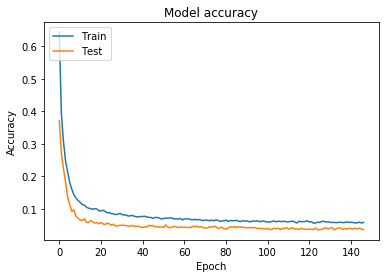

ActFrac:  MSE = 0.036622040057570214 R2 = 0.9649470421736052


In [9]:
# Evaluate training 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print('ActFrac: ', 'MSE =', 
      mean_squared_error(Y_val, model.predict(X_val)),
      'R2 =', r2_score(Y_val,model.predict(X_val)))


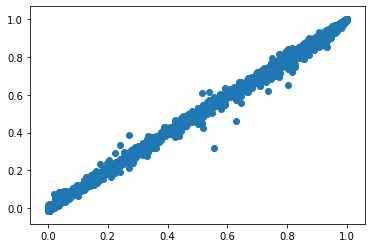

In [18]:
# Make a prediction on the test set
predVals = np.concatenate(model.predict(X_test)*Y_train_stds + Y_train_means) + data_file_test['actFrac_arg'].values
trueVals = (Y_test*Y_train_stds + Y_train_means) + data_file_test['actFrac_arg'].values
plt.scatter(trueVals,predVals)